In [1]:
import numpy as np 
import pandas as pd 
import os
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import shutil

# pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0
from torchinfo import summary

# TODO optiona for imporvement - add more images from another database/ remove watermark / segmantation - manual or by model

# Dermatological Conditions Classification
### Run a classification CNN model on different types of dermatological conditions 

In [2]:
os.makedirs('data')

## Copy Selected Data to a New Data Folder:

In [3]:
data_path = "/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/"
dest_path = '/kaggle/working/data/'
data_all = os.listdir(data_path)
print(data_all)


skin_targets = ["3. Atopic Dermatitis - 1.25k", 
                "7. Psoriasis pictures Lichen Planus and related diseases - 2k",
                "1. Eczema 1677"#, 
                # "9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k"
               ] 
#0. Warts Molluscum and other Viral Infections - 2103
#9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k

for target in skin_targets:
    target_path = data_path + target
    target_dest_path = dest_path + target
    print(f"\nTarget Name: {target}")
    print(f"Train Len: {len(os.listdir(target_path))}")
    shutil.copytree(target_path, target_dest_path)

['1. Eczema 1677', '10. Warts Molluscum and other Viral Infections - 2103', '4. Basal Cell Carcinoma (BCC) 3323', '7. Psoriasis pictures Lichen Planus and related diseases - 2k', '5. Melanocytic Nevi (NV) - 7970', '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k', '3. Atopic Dermatitis - 1.25k', '6. Benign Keratosis-like Lesions (BKL) 2624', '8. Seborrheic Keratoses and other Benign Tumors - 1.8k', '2. Melanoma 15.75k']

Target Name: 3. Atopic Dermatitis - 1.25k
Train Len: 1257

Target Name: 7. Psoriasis pictures Lichen Planus and related diseases - 2k
Train Len: 2055

Target Name: 1. Eczema 1677
Train Len: 1677


In [4]:
!pip install split_folders
import splitfolders

In [34]:
# import shutil
# shutil.rmtree('/kaggle/working/split_data')

## Change Targets' Names:

In [5]:
path = "/kaggle/working/data/"

dir_list = os.listdir(path) 
print(len(dir_list))

os.rename(path + "1. Eczema 1677", path + "Eczema")
os.rename(path + "7. Psoriasis pictures Lichen Planus and related diseases - 2k", path + "Psoriasis + Lichen Planus")
os.rename(path + "3. Atopic Dermatitis - 1.25k", path + "Atopic Dermatitis")
# os.rename(path + "9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k", path + "Fungal Infections")

3


In [6]:
path = "/kaggle/working/data"

skin_targets_renamed = os.listdir(path)
skin_targets_renamed

['Psoriasis + Lichen Planus', 'Atopic Dermatitis', 'Eczema']

## Split Data to Train, Test and Validation Folders

In [7]:
os.makedirs('split_data')
os.makedirs('split_data/train')
os.makedirs('split_data/val')
os.makedirs('split_data/test')

loc = "/kaggle/working/data/"

splitfolders.ratio(loc, output ="split_data", ratio = (0.80,.1,.1))
# splitfolders.ratio(loc, output ="split_data", ratio = (0.70,.15,.15))

Copying files: 4989 files [00:00, 5087.47 files/s]


In [8]:
path = "/kaggle/working/split_data/train/Atopic Dermatitis"
dir_list = os.listdir(path) 
print(len(dir_list))
# dir_list

1005


## Create pytorch dataset

In [9]:
train_path = "/kaggle/working/split_data/train/"
test_path = "/kaggle/working/split_data/test/"

# implement pytorch dataset:
class SkinDataset(Dataset):

    def __init__(self, mode = 'train', transform = transforms.ToTensor()):
        self.mode = mode 
        self.target_dict = {}
        self.skin_targets = skin_targets_renamed
        img_paths, img_targets = self.get_data()
        self.img_paths = img_paths
        self.img_targets = img_targets
        self.transform = transform
        
    def __len__(self): # == len(dataset)
        return len(self.img_paths)
        
    def __getitem__(self, index): # == dataset[index] 
        img = Image.open(self.img_paths[index])
        # img = img.filter(ImageFilter.GaussianBlur(radius=2)) #reduce noises
        img = self.transform(img)
        return {"img": img, "target": self.img_targets[index]}

    def get_data(self):
        dir_path = train_path if self.mode == 'train' else test_path
        image_paths = []
        image_target = []
        for i in range(len(skin_targets)):
            target_path = dir_path + self.skin_targets[i]
            self.target_dict[i] = self.skin_targets[i]
            print(f"target_path: {target_path}")
            for path in os.listdir(target_path):
                img_path = target_path + "/" + path
                image_paths.append(img_path)
                image_target.append(i) # target index
        return image_paths, image_target


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),   # Flip images randomly
    # transforms.RandomRotation(degrees=30),    # Rotate more (10 → 20 degrees)
    # transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),  # More aggressive cropping
    transforms.RandomAffine(degrees=0, shear=20),  # Increase shear for perspective shifts
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Stronger distortions
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),  # Apply perspective transformation
    # transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),  # Blur to prevent memorization
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Standard normalization
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3))  # Cutout to hide parts of the image
    # transforms.RandomErasing(p=0.5)  # Cutout to hide parts of the image
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # No augmentation for validation
    transforms.ToTensor()#,
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train = SkinDataset(mode = 'train', transform = train_transform)
print(f"train len: {len(train)}") 

test = SkinDataset(mode = 'test', transform = test_transform)
print(f"test len: {len(test)}") 

target_path: /kaggle/working/split_data/train/Psoriasis + Lichen Planus
target_path: /kaggle/working/split_data/train/Atopic Dermatitis
target_path: /kaggle/working/split_data/train/Eczema
train len: 3990
target_path: /kaggle/working/split_data/test/Psoriasis + Lichen Planus
target_path: /kaggle/working/split_data/test/Atopic Dermatitis
target_path: /kaggle/working/split_data/test/Eczema
test len: 502


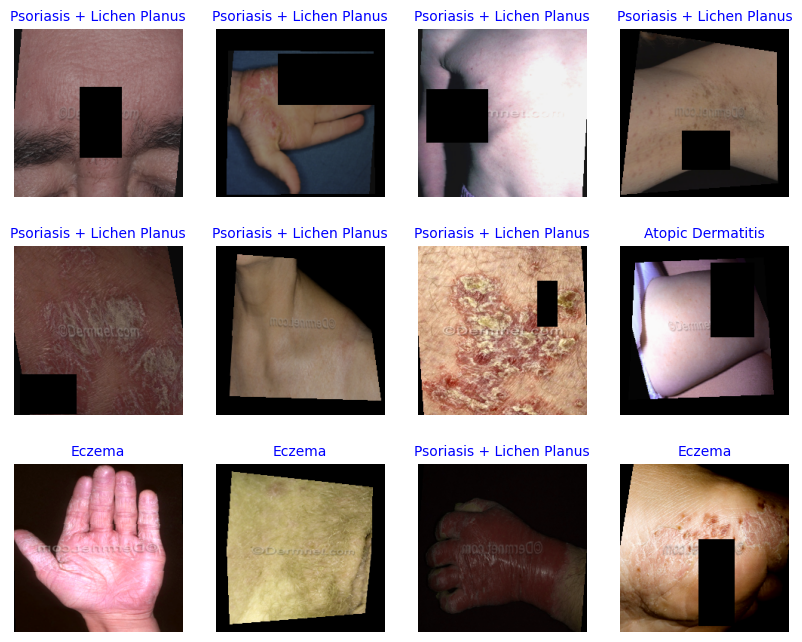

In [10]:
example_list = [train[i] for i in random.sample(range(len(train)), k=12)]

fig, axes = plt.subplots(3, 4, figsize=(10, 8))
for ax, img_item in zip(axes.ravel(), example_list):
    img = transforms.functional.to_pil_image(img_item['img'])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(train.target_dict[img_item['target']], fontsize=10, color="blue")

plt.show()

In [11]:
# Set the device
c_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pin_memory = c_device.type == 'cuda'
print(f"device: {c_device}")

# Create dataloaders for training and test sets
train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True, pin_memory=pin_memory)
test_loader = torch.utils.data.DataLoader(test, batch_size=64, pin_memory=pin_memory)

batch = next(iter(train_loader))
print(batch['img'].shape)
print(batch['target'].shape)

device: cuda
torch.Size([64, 3, 224, 224])
torch.Size([64])


# todo: torch lightinng??

In [14]:
def train_loop(dataloader, model, criterion, optimizer, device):
    size = len(dataloader.dataset)
    model.train()
    running_loss, running_corrects = 0, 0
    # iterate through all batches
    for batch in dataloader:
        X = batch['img'].to(device=device)
        y = batch['target'].to(device=device)
        pred = model(X)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += (pred.argmax(1) == y).type(torch.float).sum().item()
    epoch_loss = running_loss / size
    epoch_accuracy = 100 * running_corrects / size
    return epoch_loss, epoch_accuracy


def inference_loop(dataloader, model, criterion, device):
    size = len(dataloader.dataset)
    model.eval()
    running_loss, running_corrects = 0, 0
    # disregard gradients when not training
    with torch.no_grad():
        # iterate through all batches
        for batch in dataloader:
            X = batch['img'].to(device=device)
            y = batch['target'].to(device=device)
            pred = model(X)
            running_loss += criterion(pred, y).item()
            running_corrects += (pred.argmax(1) == y).type(torch.float).sum().item()
    epoch_loss = running_loss / size
    epoch_accuracy = 100 * running_corrects / size
    return epoch_loss, epoch_accuracy

## Add dropout layer to the network
#### Allowing "shot down" layers randomly to reduce overfitting

In [19]:
num_classes = 4
model = efficientnet_b0(weights="IMAGENET1K_V1")  # Load pre-trained weights
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.classifier[1].in_features, num_classes)  # Adjust output layer
)

# from torchvision.models import mobilenet_v3_large

# model = mobilenet_v3_large(weights="IMAGENET1K_V1")
# model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

# Transfer it to device
model = model.to(device=c_device)


# Define the loss function
criterion = nn.CrossEntropyLoss()

# define optimizer & schedulers
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # Use all parameters
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.2, min_lr=1e-6, verbose=True)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)  # Reduce LR every n epochs by a factor of 0.5

epochs = 25
test_a = []
train_a = []
test_l = []
train_l = []
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_loop(train_loader, model, criterion, optimizer, c_device)
    test_loss, test_acc = inference_loop(test_loader, model, criterion, c_device)
    print('Train', f'Epoch: {epoch:03d} / {epochs:03d}',  f'Loss: {train_loss:7.4g}', f'Accuracy: {train_acc:.3f}',  sep='   ')
    print(' Test', f'Epoch: {epoch:03d} / {epochs:03d}',  f'Loss: {test_loss:7.4g}', f'Accuracy: {test_acc:.3f}', sep='   ')
    # scheduler.step()
    test_a.append(test_acc)
    train_a.append(train_acc)
    test_l.append(test_loss)
    train_l.append(train_loss)
    scheduler.step(test_loss)


# 20 epochs, step_size=10, 20: train: 0.75, test: 0.55
# densenet121 model: 90 epochs, step_size=20, adam, lr=0.001, normalization, train: 97.920, test: 62.948
# CustomDenseNet model without augmentation: 30-40 epochs, step_size=20, adam, lr=0.001, normalization, train: 98.9, test: 73-75
# when doing augmentation lr should be small
# CustomDenseNet model with saved augmentation: 34 epochs, step_size=20, adam, lr=0.001, normalization, train: 91, test: 64 - similar results with more weak augmentation train: 99, test: 66
# efficientnet_b0 trained model - much better!! 14 epochs, train: 97, test: 76
# efficientnet_b0 trained model with fly augmentation best!! 11 epochs, train: 94, test: 78
# with 30-degree rot Train   Epoch: 026 / 040   Accuracy: 96.190 Test Accuracy: 78-80.677
# with erase : Train   Epoch: 025 / 040  Accuracy: 86.591 Test Accuracy: 75.498 - less overfitting but not very good performence
# with fugal : Epoch: 025 / 040  Accuracy: 84 Test Accuracy: 71-73
# without normalization - same results
# without normalization,  with erase + blur, with ReduceLROnPlateau patience=5, Train   Epoch: 040 / 050  Accuracy: 89.796  Accuracy: 73.848-74
# without normalization,  with erase + without blur, with ReduceLROnPlateau patience=3, Train   Epoch: 050 / 050  Accuracy: 91  Accuracy: 76
# without normalization, erase, blur, with ReduceLROnPlateau patience=3, Train   Epoch: 050 / 050  Accuracy: 93-4  Accuracy: 75
# CosineAnnealingLR, StepLR less good than ReduceLROnPlateau
# without rotation, lr=0.001, weight_decay=1e-4: Train   Epoch: 037 / 050  Accuracy: 95.291,Test Accuracy: 75.186
# without fugal - better 0.8 vs 0.76
# without fugal, Resize((224, 224)), with minimal augmentation Train  lr=0.001, weight_decay=1e-4: Epoch: 030 / 050 Accuracy: 95.313 Test  Accuracy: 80.080
# with more augmentation, random crop and Normalize: test Accuracy: 68.127

Train   Epoch: 001 / 030   Loss: 0.01633   Accuracy: 50.476
 Test   Epoch: 001 / 030   Loss: 0.01488   Accuracy: 54.781
Train   Epoch: 002 / 030   Loss: 0.01342   Accuracy: 61.303
 Test   Epoch: 002 / 030   Loss: 0.01309   Accuracy: 68.127
Train   Epoch: 003 / 030   Loss: 0.01194   Accuracy: 66.867
 Test   Epoch: 003 / 030   Loss: 0.01186   Accuracy: 68.924
Train   Epoch: 004 / 030   Loss: 0.01076   Accuracy: 71.078
 Test   Epoch: 004 / 030   Loss: 0.01178   Accuracy: 70.319
Train   Epoch: 005 / 030   Loss: 0.00981   Accuracy: 73.659
 Test   Epoch: 005 / 030   Loss: 0.01172   Accuracy: 70.120
Train   Epoch: 006 / 030   Loss: 0.009388   Accuracy: 75.338
 Test   Epoch: 006 / 030   Loss: 0.01153   Accuracy: 71.912
Train   Epoch: 007 / 030   Loss: 0.00856   Accuracy: 78.221
 Test   Epoch: 007 / 030   Loss: 0.01134   Accuracy: 73.904
Train   Epoch: 008 / 030   Loss: 0.008059   Accuracy: 79.223
 Test   Epoch: 008 / 030   Loss: 0.01179   Accuracy: 73.307
Train   Epoch: 009 / 030   Loss: 0.007

KeyboardInterrupt: 

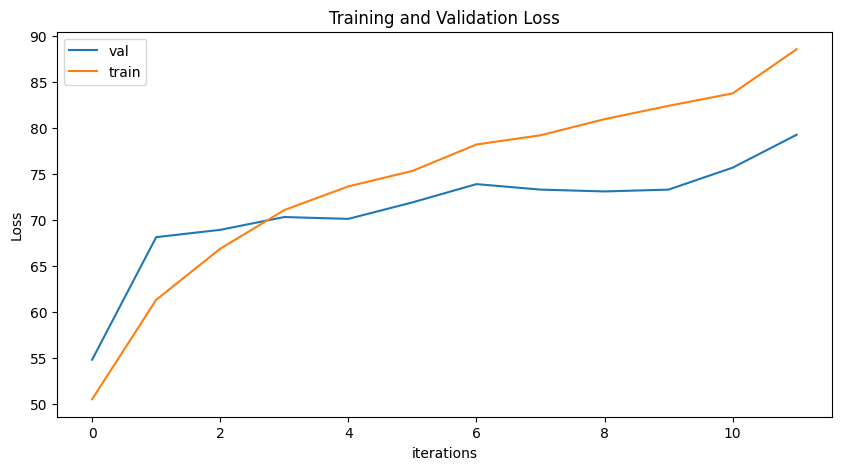

In [20]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_a,label="val")
plt.plot(train_a,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

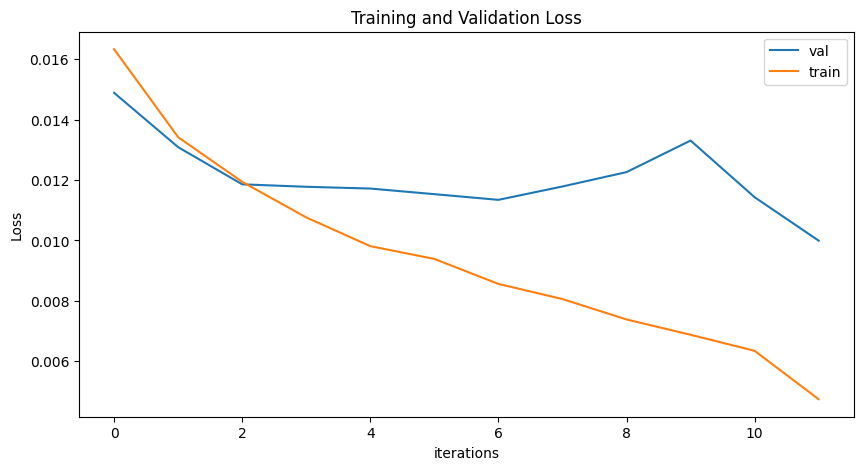

In [21]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_l,label="val")
plt.plot(train_l,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### TODO add confusion_matrix (actual vs predicted) and loss and accurcy graph 
https://www.nature.com/articles/s41598-024-80013-0